In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score

In [2]:
#importing the dataset

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#looking at the distributions of the target variable...is the dataset imbalanced?
#it doesn't look imbalanced

In [6]:
df.Survived.value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [7]:
df.shape
#891 rows and 12 columns

(891, 12)

In [8]:
#are there NAs?

In [9]:
df.isna().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

## Pclass

In [10]:
df.groupby("Pclass").Survived.mean()
#the Pclass variable looks relevant. Those in first class have higher chances of survive

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

## Sex

In [11]:
df.groupby("Sex").Survived.mean()
#the sex variable looks relevant. Being a female leads to a much higher chance of survival

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [12]:
df.groupby(["Sex", "Pclass"]).Survived.mean()

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

## Age

In [13]:
df.Age.describe()
#are the values for the age column reasonable?
#values look realistic

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Density'>

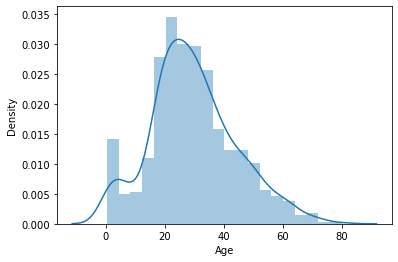

In [14]:
sns.distplot(df.Age)
#distribution of the age variable

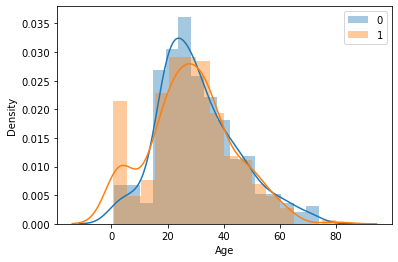

In [15]:
sns.distplot(df.loc[df.Survived == 0].Age, label = "0")
sns.distplot(df.loc[df.Survived == 1].Age, label = "1")
plt.legend()
#distribution of the age variable taking the target variable into account
#the age variable looks somehow relevant. Being younger leads to higher chances of survive while being older leads to lower chances of survive

In [16]:
#I create buckets for the age variable
df["Age_class"] = df["Age"] // 15 * 15
df.groupby(['Age_class']).Survived.mean()

Age_class
0.0     0.576923
15.0    0.362745
30.0    0.423256
45.0    0.404494
60.0    0.240000
75.0    1.000000
Name: Survived, dtype: float64

## SibSp

In [17]:
df.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [18]:
df.groupby("SibSp").Survived.mean()
#travelling with 1/2 siblings/spouses increases the chances of survival

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

## Parch 

In [19]:
df.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [20]:
df.groupby("Parch").Survived.mean()
#having 1/2/3 parents/children is associated to a higher survival rate

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

In [21]:
#As the SibSp and Parhc variables look relevant I decide to combine them in a single variable

In [22]:
df["Relatives"] = df.SibSp + df.Parch
df.groupby(['Relatives']).Survived.mean()
#it looks like travelling alone leads to lower chances of survival compared to having relatives (1-3)

Relatives
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

In [23]:
#I also create a variable indicating whether a person travels alone or not 
df["alone"] = df.Relatives.apply(lambda x:  "Yes" if x == 0 else "No" )
#I create a variable indicating whether a person is travelling with more than 3 relatives (lower chance of survival)
df["relatives_new"] = df.Relatives.apply(lambda x:  "Yes" if x > 3 else "No" )

## Fare

<AxesSubplot:xlabel='Fare', ylabel='Density'>

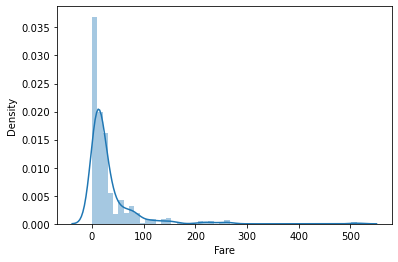

In [24]:
sns.distplot(df.Fare)

In [25]:
df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

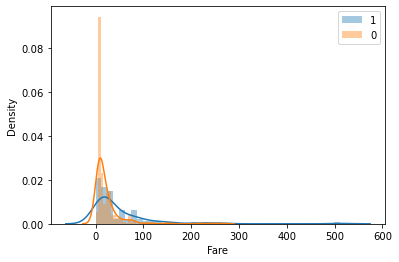

In [26]:
sns.distplot(df.loc[df.Survived == 1].Fare, label = "1")
sns.distplot(df.loc[df.Survived == 0].Fare, label = "0")
plt.legend()

<AxesSubplot:xlabel='Fare', ylabel='Density'>

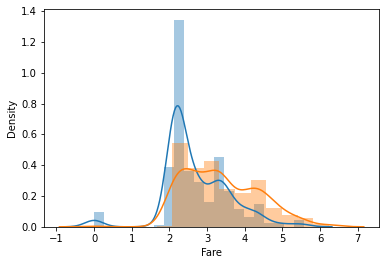

In [27]:
sns.distplot(np.log(df.loc[df.Survived == 0].Fare+1))
sns.distplot(np.log(df.loc[df.Survived == 1].Fare+1))

In [28]:
df.loc[df.Fare > 200]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_class,Relatives,alone,relatives_new
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,15.0,5,No,Yes
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,15.0,5,No,Yes
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,15.0,1,No,No
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,30.0,0,Yes,No
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,45.0,1,No,No
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,15.0,4,No,Yes
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,15.0,5,No,Yes
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,15.0,2,No,No
380,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C,30.0,0,Yes,No
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,60.0,5,No,Yes


In [29]:
df[["Fare", "Pclass"]].corr()

,Fare,Pclass
Fare,1.0000,-0.5495
Pclass,-0.5495,1.0000


In [30]:
#I create a log transformed variable for the fare
df["log_fare"] = np.log(df.Fare+1)
#I create buckets for the log transformed fare variable
df["fare_bucket"] = df["log_fare"] // 1.5 * 1.5
df.groupby(['fare_bucket']).Survived.mean()

fare_bucket
0.0    0.066667
1.5    0.276423
3.0    0.489097
4.5    0.750000
6.0    1.000000
Name: Survived, dtype: float64

## Embarked

In [31]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [33]:
df.groupby("Embarked").Survived.mean()
#the variable looks relevant...people tham embarked in different locations have different survival rates

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [35]:
df.groupby(["Embarked","Pclass"]).Survived.mean()

Embarked  Pclass
C         1         0.694118
          2         0.529412
          3         0.378788
Q         1         0.500000
          2         0.666667
          3         0.375000
S         1         0.582677
          2         0.463415
          3         0.189802
Name: Survived, dtype: float64

## Cleaning the dataset

In [34]:
#as the age column has many NAs I fill them using a value which is the average age value based on the title of the passenger

In [35]:
miss_mean_age_train = df.loc[df.Name.str.contains("Miss.")].Age.mean(skipna = True)
mr_mean_age_train = df.loc[df.Name.str.contains("Mr. ")].Age.mean(skipna = True)
mrs_mean_age_train = df.loc[df.Name.str.contains("Mrs. ")].Age.mean(skipna = True)
master_mean_age_train = df.loc[df.Name.str.contains("Master.")].Age.mean(skipna = True)


print('Mr: ', mr_mean_age_train)
print('Mrs: ', mrs_mean_age_train)
print('Master: ', master_mean_age_train)
print('Miss: ', miss_mean_age_train)

Mr:  32.332089552238806
Mrs:  35.898148148148145
Master:  4.574166666666667
Miss:  21.773972602739725


In [36]:
df.loc[(df.Name.str.contains('Miss.'))&(df.Age.isnull()),"Age"] = 22
df.loc[(df.Name.str.contains('Mr.'))&(df.Age.isnull()),"Age"] = 32
df.loc[(df.Name.str.contains('Mrs'))&(df.Age.isnull()),"Age"] = 36
df.loc[(df.Name.str.contains('Master'))&(df.Age.isnull()),"Age"] = 5
df.loc[(df.Name.str.contains('Dr.'))&(df.Age.isnull()), "Age"] = 40

In [37]:
#I create a new column "Title"

In [38]:
df.loc[df.Name.str.contains('Dr.'), "Title"] = "Dr"
df.loc[df.Name.str.contains('Master.'), "Title"] = "Master"
df.loc[df.Name.str.contains('Mrs.'), "Title"] = "Mrs"
df.loc[df.Name.str.contains('Mr.'), "Title"] = "Mr"
df.loc[df.Name.str.contains('Miss.'), "Title"] = "Miss"
df.Title.fillna(value= "other", inplace=True)

In [39]:
#probability of survive based on the title of the passenger

In [40]:
print(df.loc[(df.Name.str.contains('Miss.'))].Survived.mean())
print(df.loc[(df.Name.str.contains('Mr.'))].Survived.mean())
print(df.loc[(df.Name.str.contains('Mrs.'))].Survived.mean())
print(df.loc[(df.Name.str.contains('Master.'))].Survived.mean())
print(df.loc[(df.Name.str.contains('Dr.'))].Survived.mean())


0.6978021978021978
0.28438948995363217
0.7906976744186046
0.575
0.5454545454545454


In [41]:
#I drop not relevant features and remove rows with NAs

In [42]:
df.drop(columns=["PassengerId", "Ticket", "Cabin"], inplace=True)

In [43]:
df.dropna(inplace=True)

In [44]:
df.shape

(712, 16)

In [45]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Age_class', 'Relatives', 'alone', 'relatives_new',
       'log_fare', 'fare_bucket', 'Title'],
      dtype='object')

# Creating the model

In [46]:
X = df[['Pclass', 'Age_class',"Sex", "fare_bucket",
       'Embarked', "alone", "relatives_new"]]
y = df.Survived

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123, stratify = y)

In [48]:
#mkt = make_column_transformer((StandardScaler(), ["log_fare" ]), (OneHotEncoder(handle_unknown="ignore"), ["relatives_new","Age_class","Pclass","alone","Embarked", "Sex"]), remainder='passthrough')
mkt = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), ["fare_bucket","relatives_new","Age_class","Pclass","alone","Embarked", "Sex"]), remainder='passthrough')

In [49]:
random = RandomForestClassifier()
paramsRandom = {"randomforestclassifier__n_estimators": [50,60,70,80,90,100], "randomforestclassifier__max_depth": [2,3,4,5], "randomforestclassifier__random_state": [123]}

In [50]:
pipe = make_pipeline(mkt, random)

In [51]:
grid = GridSearchCV(pipe, param_grid = paramsRandom, cv = 5, scoring="accuracy")

### Fitting the model

In [52]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['fare_bucket',
                                                                          'relatives_new',
                                                                          'Age_class',
                                                                          'Pclass',
                                                                          'alone',
                                                                          'Embarked',
                                                                          'Sex'])])),
                            

In [53]:
grid.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__n_estimators': 90,
 'randomforestclassifier__random_state': 123}

In [54]:
grid.best_score_

0.8066915075298867

### Making predictions and evaluating the model

In [55]:
y_pred = grid.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred)



0.8321678321678322

Text(0.5, 1.0, 'Confusion Matrix')

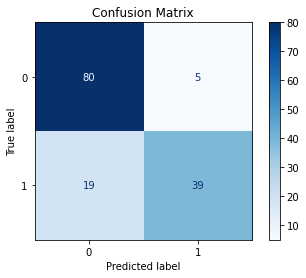

In [58]:
plot_confusion_matrix(grid, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

In [60]:
#I extract the predicted probability for both classes and add them to the test dataset

In [61]:
probability_1 = pd.DataFrame(grid.predict_proba(X_test)[:,1], columns=["probability_1"])
probability_0 = pd.DataFrame(grid.predict_proba(X_test)[:,0], columns=["probability_0"])

In [62]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [63]:
pd.set_option('display.max_rows', None)
final_test_data = pd.concat([X_test, y_test, probability_0, probability_1], axis=1)
final_test_data

,Pclass,Age_class,Sex,fare_bucket,Embarked,alone,relatives_new,Survived,probability_0,probability_1
0,2,30.0,male,1.5,S,Yes,No,0,0.801212,0.198788
1,2,30.0,male,1.5,S,Yes,No,0,0.801212,0.198788
2,3,15.0,male,1.5,S,Yes,No,0,0.872974,0.127026
3,1,15.0,female,3.0,C,No,No,1,0.065731,0.934269
4,3,30.0,female,1.5,S,Yes,No,1,0.575676,0.424324
5,1,30.0,female,4.5,Q,No,No,1,0.179641,0.820359
6,3,30.0,male,1.5,S,Yes,No,0,0.844315,0.155685
7,1,15.0,female,3.0,S,Yes,No,1,0.124033,0.875967
8,3,15.0,male,1.5,S,Yes,No,1,0.872974,0.127026
9,3,15.0,female,1.5,S,No,No,0,0.510508,0.489492


# Predictions for submissions

In [82]:
test = pd.read_csv("test.csv")

In [83]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [84]:
test.shape

(418, 11)

In [85]:
test.isna().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

In [86]:
#I fill the NAs for the age variable like I did previously

In [87]:
test.loc[(test.Name.str.contains('Miss.'))&(test.Age.isnull()),"Age"] = 22
test.loc[(test.Name.str.contains('Ms.'))&(test.Age.isnull()),"Age"] = 22
test.loc[(test.Name.str.contains('Mr.'))&(test.Age.isnull()),"Age"] = 32
test.loc[(test.Name.str.contains('Mrs'))&(test.Age.isnull()),"Age"] = 36
test.loc[(test.Name.str.contains('Master'))&(test.Age.isnull()),"Age"] = 5
test.loc[(test.Name.str.contains('Dr.'))&(test.Age.isnull()), "Age"] = 40

In [88]:
test.isna().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

In [89]:
test.loc[test.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [90]:
df.groupby("Pclass").Fare.mean()

Pclass
1    88.048121
2    21.471556
3    13.229435
Name: Fare, dtype: float64

In [91]:
#as there is one observation with missing value for the Fare variable and it refers to a passenger who travelled in 3rd class I fill it with the mean fare value of people travelling in the same class
test.Fare.fillna(value= 14, inplace=True)

In [92]:
test.isna().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.782297
Embarked       0.000000
dtype: float64

In [93]:
#I create new variables as I did before
test["log_fare"] = np.log(test.Fare+1)
test["Relatives"] = test.SibSp + test.Parch
test["alone"] = test.Relatives.apply(lambda x:  "Yes" if x == 0 else "No" )
test["Age_class"] = test["Age"] // 15 * 15
test["relatives_new"] = test.Relatives.apply(lambda x:  "Yes" if x > 3 else "No" )
test["fare_bucket"] = test["log_fare"] // 1.5 * 1.5


In [94]:
test.loc[test.Name.str.contains('Dr.'), "Title"] = "Dr"
test.loc[test.Name.str.contains('Master.'), "Title"] = "Master"
test.loc[test.Name.str.contains('Mrs.'), "Title"] = "Mrs"
test.loc[test.Name.str.contains('Mr.'), "Title"] = "Mr"
test.loc[test.Name.str.contains('Miss.'), "Title"] = "Miss"
test.Title.fillna(value= "other", inplace=True)


In [95]:
#I retain only the relevant variables

In [96]:
test_id = test["PassengerId"]

In [97]:
X_test = test[['Pclass', 'Age_class',"Sex", "fare_bucket",
       'Embarked', "alone", "relatives_new"]]

In [98]:
# I compute predictions and store them in a csv file as requested by the Kaggle'submission rules

In [99]:
test_pred = grid.predict(X_test)

In [100]:
results = pd.DataFrame({"PassengerID": test_id, "Survived": test_pred})

In [102]:
results.to_csv("Titanic_submission_final.csv", index = False)

In [104]:
#I ended up obtaining an accuracy = 0.799% (I positioned myself around 2880 out of 55k+ participants)